In [2]:
import sys
!{sys.executable} -m pip install matplotlib

### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from tqdm import tqdm
import pandas as pd

### Query
from astroquery.sdss import SDSS

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install lmfit

  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sdss 0.2.4 requires pandas, which is not installed.
astroml 1.0.2.post1 requires astropy>=3.0, which is not installed.
astroml 1.0.2.post1 requires scikit-learn>=0.18, which is not installed.
astroml 1.0.2.post1 requires scipy>=0.18, which is not installed.


AttributeError: module 'matplotlib' has no attribute 'rcParams'

In [2]:
df = pd.read_csv("data/sdssdr14-wd-catalog/Table2.csv")

ps = []
ms = []
fs = []

for i in range(len(df['P-M-F'])):
    tpmf = df['P-M-F'][i].split('-')
        
    ps.append(int(tpmf[0]))
    ms.append(int(tpmf[1]))
    fs.append(int(tpmf[2]))
        
df['plate'] = ps
df['mjd'] = ms
df['fiber'] = fs

C:\Users\arsen\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
from astropy.coordinates import SkyCoord
from astropy import units as u

i = df['SNg'].tolist().index(max(df['SNg']))

xid = SDSS.get_spectra_async(plate=df['plate'][i], fiberID=df['fiber'][i], mjd=df['mjd'][i])
url = str(xid[0]).split(' ')[4]
print(url)

https://data.sdss.org/sas/dr14/sdss/spectro/redux/26/spectra/2682/spec-2682-54401-0422.fits


In [4]:
from astropy.io import fits
star = fits.open(url)

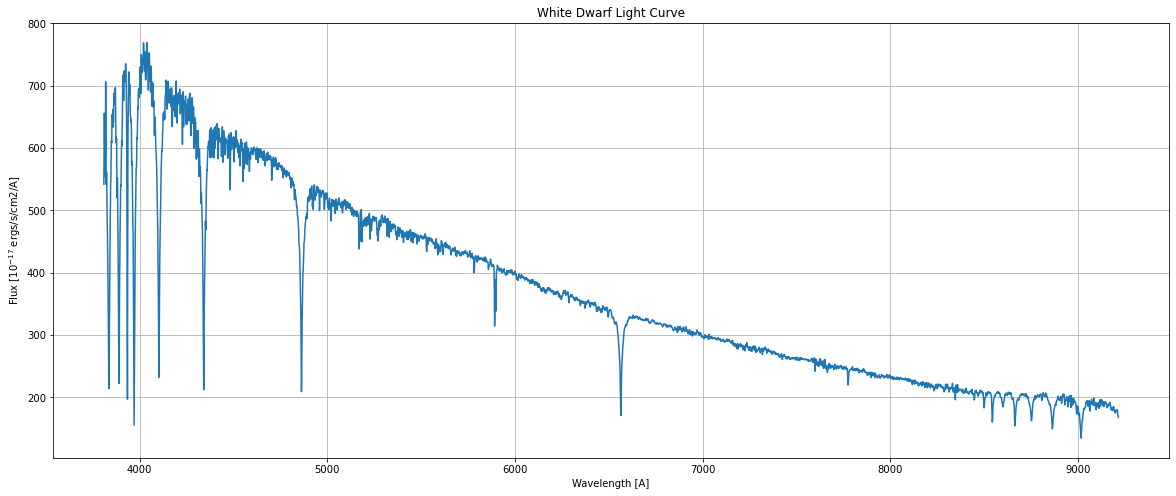

In [5]:
##### https://www.sdss.org/dr17/spectro/spectro_basics/
# https://data.sdss.org/datamodel/files/SPECTRO_REDUX/RUN2D/PLATE4/spCFrame.html

header = star[1].header
data = star[1].data

wavelength = 10**data['loglam']
flux = data['flux']

plt.figure(figsize=(20,8))

plt.plot(wavelength, flux)
plt.grid()
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title('White Dwarf Light Curve')
ax = plt.gca()

plt.show()

[[Model]]
    (Model(constant, prefix='offset_') + Model(gaussian, prefix='p_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 180
    # data points      = 86
    # variables        = 4
    chi-square         = 8464.36972
    reduced chi-square = 103.224021
    Akaike info crit   = 402.677524
    Bayesian info crit = 412.494913
[[Variables]]
    offset_c:     324.960107 +/- 1.31821922 (0.41%) (init = 350)
    p_amplitude: -2234.41890 +/- 95.2884791 (4.26%) (init = -300)
    p_center:     6563.91551 +/- 0.30940793 (0.00%) (init = 6550)
    p_sigma:      7.56048717 +/- 0.33170867 (4.39%) (init = 100)
    p_fwhm:       17.8035864 +/- 0.78111421 (4.39%) == '2.3548200*p_sigma'
    p_height:    -117.903013 +/- 4.28141292 (3.63%) == '0.3989423*p_amplitude/max(1e-15, p_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(p_amplitude, p_sigma)  = -0.648
    C(offset_c, p_amplitude) = -0.556
    C(offset_c, p_sigma)     = 0.360


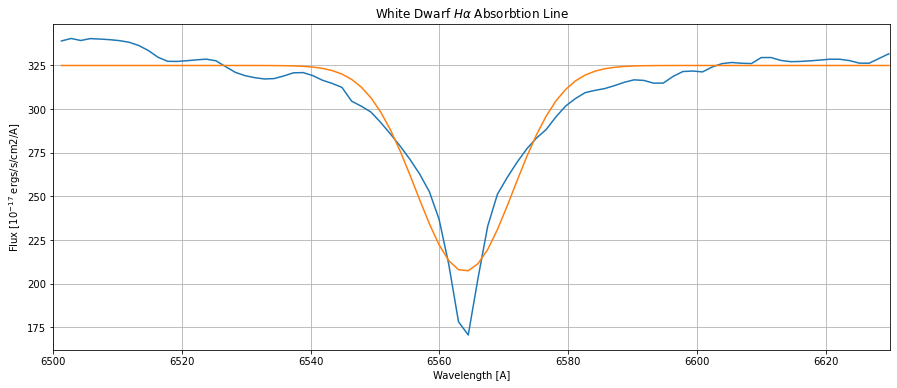

In [51]:
from lmfit.models import GaussianModel, ConstantModel

ha = np.where(np.logical_and([wavelength > 6500], [wavelength < 6630]))[1]

x = wavelength[ha]
y = flux[ha]

model = (ConstantModel(prefix='offset_') +
         GaussianModel(prefix='p_'))

params = model.make_params(offset_c=350, p_amplitude=-300., p_sigma=100, p_center=6550) 
init = model.eval(params, x=x)
result = model.fit(y, params, x=x)

print(result.fit_report())

plt.figure(figsize=(15,6))

plt.plot(wavelength[ha], flux[ha])
plt.plot(wavelength[ha], result.best_fit)
plt.xlim((6500,6630))
#plt.ylim((150,400))
plt.grid()
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title(r'White Dwarf $H\alpha$ Absorbtion Line')
ax = plt.gca()

plt.show()

In [69]:
lambda_obs = result.params['p_center'].value
dlambda_obs = result.params['p_center'].stderr

v_app = 3e8 * (((lambda_obs*1e-10) - (6550*1e-10)) / (6550*1e-10)) * 1e-3
print('Observed speed by redshift: %.2f km/s' % (v_app))

Observed speed by redshift: 637.35 km/s
